<a href="https://colab.research.google.com/github/youngwoo3283/project2-section02/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 롤 데이터를 이용한 승부예측

- 사용할 데이터셋 : 최상위 티어의 경기 기록

- 문제 정의 : 프로팀에서 승률을 올리기 위한 전략의 필요성

- 시나리오 : 롤 프로팀에서 승률이 안 좋은 팀을 위해서 데이터를 분석한 전략을 세우려고 한다. 프로게이머팀은 승률이 높아야 인기가 많으며 스폰서 및 광고를 통해서 수익을 올릴 수 있기 때문에 승리가 중요하다.
   - 이때 승리/패배의 이진 분류를 사용한다.
   - 타겟값 : 게임의 승리/패배


## 가설 
- 4용을 처치하는게 유리하여서 4용이 게임에 승패에 영향을 미칠 것이다.
- 첫번째 타워를 부수는 것이 승패에 영향을 미칠 것이다.
- 게임이 길어지면 승패에 영향을 미칠까??


- 스펠은 어떤 것을 많이 들고 영향이 있을까?
- 어떤 챔피언이 픽률이 좋고 어떤 챔피언이 밴을 가장 잘 될까??

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_game = pd.read_csv('/content/drive/MyDrive/archive (2)/games.csv')

# 데이터 준비하기
 - 타겟 : winner

In [40]:
data_game.head()

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,...,5,0,0,1,1,114,67,43,16,51
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,...,2,0,0,0,0,11,67,238,51,420
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,...,2,0,0,1,0,157,238,121,57,28
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,...,0,0,0,0,0,164,18,141,40,51
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,...,3,0,0,1,0,86,11,201,122,18


In [4]:
data_champ = pd.read_json('/content/drive/MyDrive/archive (2)/champion_info.json')

In [5]:
data_champ2 = pd.read_json('/content/drive/MyDrive/archive (2)/champion_info_2.json')

In [6]:
data_spell = pd.read_json('/content/drive/MyDrive/archive (2)/summoner_spell_info.json')

In [7]:
champInfo = pd.read_json((data_champ['data']).to_json(), orient='index') 

In [8]:
champInfo2 = pd.read_json((data_champ2["data"]).to_json(),orient = "index")

In [9]:

data_spell_info = pd.read_json((data_spell['data']).to_json(), orient='index')

data_game2 = pd.read_csv('/content/drive/MyDrive/archive (2)/games.csv')

winner = data_game2[["winner"]]
winner = winner.T
winner.shape

(1, 51490)

In [10]:
name_dict = pd.Series(champInfo.key.values,index=champInfo.id).to_dict()

In [11]:
champInfo2

,tags,title,id,key,name
Aatrox,"[Fighter, Tank]",the Darkin Blade,266,Aatrox,Aatrox
Ahri,"[Mage, Assassin]",the Nine-Tailed Fox,103,Ahri,Ahri
Akali,[Assassin],the Fist of Shadow,84,Akali,Akali
Alistar,"[Tank, Support]",the Minotaur,12,Alistar,Alistar
Amumu,"[Tank, Mage]",the Sad Mummy,32,Amumu,Amumu
...,...,...,...,...,...
Zac,"[Tank, Fighter]",the Secret Weapon,154,Zac,Zac
Zed,"[Assassin, Fighter]",the Master of Shadows,238,Zed,Zed
Ziggs,[Mage],the Hexplosives Expert,115,Ziggs,Ziggs
Zilean,"[Support, Mage]",the Chronokeeper,26,Zilean,Zilean


In [69]:
data_game.winner

0        1
1        1
2        1
3        1
4        1
        ..
51485    2
51486    2
51487    2
51488    2
51489    1
Name: winner, Length: 51490, dtype: int64

## 데이터 전처리하기

먼저 타겟값의 불균형을 확인하자
- 1은 1팀이 이겼다는 뜻이고 2는 2팀이 이겼다는 뜻이다
- 딱 봐도 비슷하니 딱히 불균형 해소를 위한 스케일링은 필요없다

In [36]:
data_game.winner.value_counts()

1    26077
2    25413
Name: winner, dtype: int64

## 선택한 챔피언과 금지한 챔피언 정보는 따로 저장한다

In [41]:
champs = data_game[["t1_champ1id","t1_champ2id",
                      "t1_champ3id","t1_champ4id","t1_champ5id","t2_champ1id",
                      "t2_champ2id","t2_champ3id","t2_champ4id","t2_champ5id","t1_ban1","t1_ban2","t1_ban3",
                      "t1_ban4","t1_ban5","t2_ban1","t2_ban2","t2_ban3","t2_ban4","t2_ban5"]]

In [42]:
champs

,t1_champ1id,t1_champ2id,t1_champ3id,t1_champ4id,t1_champ5id,t2_champ1id,t2_champ2id,t2_champ3id,t2_champ4id,t2_champ5id,t1_ban1,t1_ban2,t1_ban3,t1_ban4,t1_ban5,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,8,432,96,11,112,104,498,122,238,412,92,40,69,119,141,114,67,43,16,51
1,119,39,76,10,35,54,25,120,157,92,51,122,17,498,19,11,67,238,51,420
2,18,141,267,68,38,69,412,126,24,22,117,40,29,16,53,157,238,121,57,28
3,57,63,29,61,36,90,19,412,92,22,238,67,516,114,31,164,18,141,40,51
4,19,29,40,119,134,37,59,141,38,51,90,64,412,25,31,86,11,201,122,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,19,429,91,432,64,45,83,67,40,79,114,18,11,157,497,55,-1,90,238,157
51486,90,32,31,412,18,102,429,89,75,45,157,164,122,99,420,157,55,119,154,105
51487,141,18,432,81,68,1,119,33,43,99,238,31,24,53,11,113,122,53,11,157
51488,121,236,420,201,99,21,56,25,30,11,119,64,51,157,29,154,39,51,90,114


### 유저가 선택한 캐릭터나 밴한 캐릭터는 따로 저장했으니 제외하고 게임 id는 분석에서 의미없으니 데이터에서 제외한다.

### gameid와 creationtime도 분석에 필요없으니 제외한다

In [48]:
data_game.drop(["t1_champ1id","t1_champ2id",
                      "t1_champ3id","t1_champ4id","t1_champ5id","t2_champ1id",
                      "t2_champ2id","t2_champ3id","t2_champ4id","t2_champ5id","t1_ban1","t1_ban2","t1_ban3",
                      "t1_ban4","t1_ban5","t2_ban1","t2_ban2","t2_ban3","t2_ban4","t2_ban5","seasonId"],axis = 1,inplace = True)

In [49]:
data_game.drop(["gameId"],axis = 1,inplace = True)
data_game.drop(["creationTime"],axis = 1,inplace = True)


In [50]:
data_game.head()

,gameDuration,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_champ1_sum1,t1_champ1_sum2,...,t2_champ3_sum2,t2_champ4_sum1,t2_champ4_sum2,t2_champ5_sum1,t2_champ5_sum2,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills
0,1949,1,2,1,1,1,1,2,12,4,...,4,14,4,4,3,5,0,0,1,1
1,1851,1,1,1,1,0,1,1,7,4,...,4,4,14,4,7,2,0,0,0,0
2,1493,1,2,1,1,1,2,0,4,7,...,12,4,11,7,4,2,0,0,1,0
3,1758,1,1,1,1,1,1,0,4,12,...,3,4,14,4,7,0,0,0,0,0
4,2094,1,2,1,1,1,1,0,4,12,...,4,4,12,4,7,3,0,0,1,0


# 첫번째 상황이 나온 상황에서 타겟값과의 상관계수를 구해보자

## 첫번째 드래곤을 처치한 경우
## 첫번째 전령을 처치한 경우
## 첫번째 바론을 처치한 경우
## 첫번째 상대팀 챔피언을 처치한 경우

## 첫번째 타워를 파괴한 경우
## 첫번째 억제기를 파괴한 경우

+) 게임시간과 승패와의 상관관계도 확인해보자

In [17]:
#확인할 칼럼들 

first = [col for col in data_game.columns if "first" in col]
first

['firstBlood',
 'firstTower',
 'firstInhibitor',
 'firstBaron',
 'firstDragon',
 'firstRiftHerald']

In [53]:
corr_li = []

for i in first:
  print(i,data_game[[i,"winner"]].corr().iloc[0,1])
  corr_li.append(data_game[[i,"winner"]].corr().iloc[0,1])

firstBlood 0.17477043886061475
firstTower 0.3756965760481061
firstInhibitor 0.5364369592048327
firstBaron 0.2618875450017928
firstDragon 0.3103855881962747
firstRiftHerald 0.11981299965040347


In [51]:
data_game[['gameDuration','winner']].corr()

,gameDuration,winner
gameDuration,1.000000,0.024187
winner,0.024187,1.000000


상관계수 해석
- 첫번째 억제기를 파괴하였을때는 승리와 상관관계가 있다고 할 수있다.
- 나머지는 약한 상관관계를 보인다고 보면 된다.


- 게임 시간과 승리와는 상관관계가 없다고 보면 된다.


## 상관계수 그래프도 가능할까??

In [62]:
corr_li.sort(reverse=True)
corr_li

[0.5364369592048327,
 0.3756965760481061,
 0.3103855881962747,
 0.2618875450017928,
 0.17477043886061475,
 0.11981299965040347]

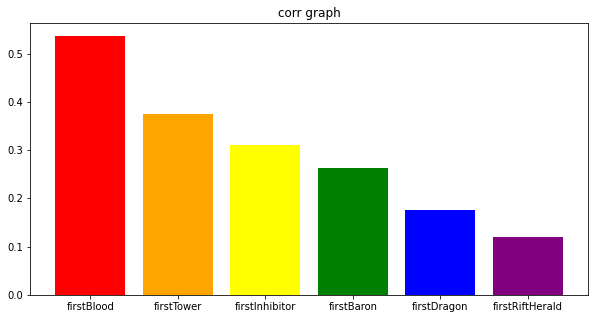

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize = (10,5))

plt.title('corr graph')
plt.bar(first,corr_li,color = ['red', 'orange', 'yellow', 'green','blue','purple']);

In [80]:
data_game[["firstInhibitor","winner"]].groupby(["firstInhibitor"],as_index = False).mean().sort_values(by = "winner",ascending = False)

,firstInhibitor,winner
1,1,0.908693
0,0,0.511472
2,2,0.086552


여기서 보면 억제기를 2팀이 미는 경우 winner의 평균이 거의 2에 가깝고 억제기를 1팀이 미는 경우 winner의 평균이 거의 1에 가까운것을 확인 할 수 있다.

따라서 억제기를 먼저 미는 것과 승리와의 상관관계가 강하다고 할 수 있다.

# 스펠 분석을 하기 위한 전처리 과정
- 각 라인에서 주로 쓰이는 스펠을 조사한다
- 만약 한 라인이라도 주로 쓰이는 스펠을 들지 않을때 승률이 올라가는지를 확인하고 싶다
- 주로 쓰이는 스펠을 들고 있는지 (yes:1 no : 0) 칼럼을 만들자

## 스펠 설명

- 1 : 정화 
- 3 : 탈진
- 4 : 점멸
- 6 : 유체화
- 7 : 힐
- 11 : 강타
- 12 : 순간이동
- 13 : 총명
- 14 : 점화
- 21 : 방어막

[스킬에 대한 정보](https://namu.wiki/w/%EC%86%8C%ED%99%98%EC%82%AC%20%EC%A3%BC%EB%AC%B8#s-4.2)

In [26]:
data_game.t1_champ1_sum1.value_counts()

4     28164
12     4968
11     4711
7      4581
14     3820
3      3640
6       744
21      702
1       160
Name: t1_champ1_sum1, dtype: int64

In [25]:
[i for i in data_game.columns if 'sum' in i]

['t1_champ1_sum1',
 't1_champ1_sum2',
 't1_champ2_sum1',
 't1_champ2_sum2',
 't1_champ3_sum1',
 't1_champ3_sum2',
 't1_champ4_sum1',
 't1_champ4_sum2',
 't1_champ5_sum1',
 't1_champ5_sum2',
 't2_champ1_sum1',
 't2_champ1_sum2',
 't2_champ2_sum1',
 't2_champ2_sum2',
 't2_champ3_sum1',
 't2_champ3_sum2',
 't2_champ4_sum1',
 't2_champ4_sum2',
 't2_champ5_sum1',
 't2_champ5_sum2']

In [27]:
data_game.t1_champ1_sum2.value_counts()

4     22216
12     6395
7      5758
11     5635
14     5205
3      4394
21      890
6       798
1       199
Name: t1_champ1_sum2, dtype: int64

In [28]:
data_spell.data

1     {'id': 1, 'summonerLevel': 6, 'name': 'Cleanse...
11    {'id': 11, 'summonerLevel': 10, 'name': 'Smite...
12    {'id': 12, 'summonerLevel': 6, 'name': 'Telepo...
13    {'id': 13, 'summonerLevel': 1, 'name': 'Clarit...
14    {'id': 14, 'summonerLevel': 10, 'name': 'Ignit...
21    {'id': 21, 'summonerLevel': 4, 'name': 'Barrie...
3     {'id': 3, 'summonerLevel': 4, 'name': 'Exhaust...
30    {'id': 30, 'summonerLevel': 1, 'name': 'To the...
31    {'id': 31, 'summonerLevel': 1, 'name': 'Poro T...
32    {'id': 32, 'summonerLevel': 1, 'name': 'Mark',...
33    {'id': 33, 'summonerLevel': 1, 'name': 'Nexus ...
34    {'id': 34, 'summonerLevel': 1, 'name': 'Nexus ...
35    {'id': 35, 'summonerLevel': 1, 'name': 'Disabl...
36    {'id': 36, 'summonerLevel': 1, 'name': 'Disabl...
4     {'id': 4, 'summonerLevel': 8, 'name': 'Flash',...
6     {'id': 6, 'summonerLevel': 1, 'name': 'Ghost',...
7     {'id': 7, 'summonerLevel': 1, 'name': 'Heal', ...
Name: data, dtype: object

# 롤 api 코드 구현 연습 (실현 못함 ㅠㅠ)

# 스펠은 불가능하니 total과 first로 모델링하기

의문점) 스펠이 모델에 성능에 영향을 미칠지??

### 결측값은 없다

In [29]:
## 결측값이 있는지 확인하기

data_game.isnull().sum()

winner                0
firstBlood            0
firstTower            0
firstInhibitor        0
firstBaron            0
firstDragon           0
firstRiftHerald       0
t1_champ1_sum1        0
t1_champ1_sum2        0
t1_champ2_sum1        0
t1_champ2_sum2        0
t1_champ3_sum1        0
t1_champ3_sum2        0
t1_champ4_sum1        0
t1_champ4_sum2        0
t1_champ5_sum1        0
t1_champ5_sum2        0
t1_towerKills         0
t1_inhibitorKills     0
t1_baronKills         0
t1_dragonKills        0
t1_riftHeraldKills    0
t2_champ1_sum1        0
t2_champ1_sum2        0
t2_champ2_sum1        0
t2_champ2_sum2        0
t2_champ3_sum1        0
t2_champ3_sum2        0
t2_champ4_sum1        0
t2_champ4_sum2        0
t2_champ5_sum1        0
t2_champ5_sum2        0
t2_towerKills         0
t2_inhibitorKills     0
t2_baronKills         0
t2_dragonKills        0
t2_riftHeraldKills    0
dtype: int64

먼저 타겟(winner)를 이용한 기준 모델 만들기
(타겟의 최빈값을 이용함)

기준모델 : 0.51

In [30]:
from sklearn.metrics import accuracy_score


base_major  = data_game['winner'].mode()[0]
y_pred_base = [base_major] * len(data_game['winner'])
accuracy_score1 = accuracy_score(data_game['winner'], y_pred_base)
accuracy_score1

0.5064478539522237

### 학습 데이터, 검증데이터, 테스트 데이터로 나누기

In [31]:
from sklearn.model_selection import train_test_split


train,test = train_test_split(data_game,test_size = 0.2, random_state = 42)

In [32]:
print(train.shape, test.shape)

(41192, 37) (10298, 37)


피쳐와 타겟에 따라서 X_train,y_train,X_test,y_test 만들기

In [33]:
data_game.columns

Index(['winner', 'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron',
       'firstDragon', 'firstRiftHerald', 't1_champ1_sum1', 't1_champ1_sum2',
       't1_champ2_sum1', 't1_champ2_sum2', 't1_champ3_sum1', 't1_champ3_sum2',
       't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5_sum1', 't1_champ5_sum2',
       't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills',
       't1_riftHeraldKills', 't2_champ1_sum1', 't2_champ1_sum2',
       't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3_sum1', 't2_champ3_sum2',
       't2_champ4_sum1', 't2_champ4_sum2', 't2_champ5_sum1', 't2_champ5_sum2',
       't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills',
       't2_riftHeraldKills'],
      dtype='object')

### 우선 스펠 관련 특성이 굉장히 많은데 이 역시 포함해서 모델을 만들어보고 이후에 빼서 모델을 만들어 보자

학습데이터와 테스트 데이터 나누기

In [34]:
features = data_game.drop(columns = 'winner').columns
target = 'winner'


X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


In [35]:
data_game.columns

Index(['winner', 'firstBlood', 'firstTower', 'firstInhibitor', 'firstBaron',
       'firstDragon', 'firstRiftHerald', 't1_champ1_sum1', 't1_champ1_sum2',
       't1_champ2_sum1', 't1_champ2_sum2', 't1_champ3_sum1', 't1_champ3_sum2',
       't1_champ4_sum1', 't1_champ4_sum2', 't1_champ5_sum1', 't1_champ5_sum2',
       't1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills',
       't1_riftHeraldKills', 't2_champ1_sum1', 't2_champ1_sum2',
       't2_champ2_sum1', 't2_champ2_sum2', 't2_champ3_sum1', 't2_champ3_sum2',
       't2_champ4_sum1', 't2_champ4_sum2', 't2_champ5_sum1', 't2_champ5_sum2',
       't2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills',
       't2_riftHeraldKills'],
      dtype='object')

수치데이터 - 총 타워킬, 총 용 킬 등등

범주형데이터 - 첫번째 용을 먹었나? (1/0) 등등